# Acknowledgement

Parts of this pset were inspired by
* Berkeley CS294-158, taught by Pieter Abbeel, Wilson Yan, Kevin Frans, and Philipp Wu;
* MIT 6.S184/6.S975, taught by Peter Holderrieth and Ezra Erives;
* The [blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) about diffusion models by Lilian Weng.




# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file.

Specifically, for Problem 2 in this notebook, the pdf should contain:
- The generated figures `results/p2_train_plot.png` and `results/p2_toy_samples.png`

# Problem 2: Training Diffusion Models on a Toy Dataset
In this problem, we will write the code for training and sampling from a diffusion model on a 2D toy dataset. This part requires GPUs--you can use Google Colab for GPU access. To work on this notebook in Google Colab, copy the `pset-5` directory to your Google Drive and open this notebook. Then, start working on a GPU machine with `Runtime -> Change runtime type -> T4 GPU`.

## Data Generation and Visualization

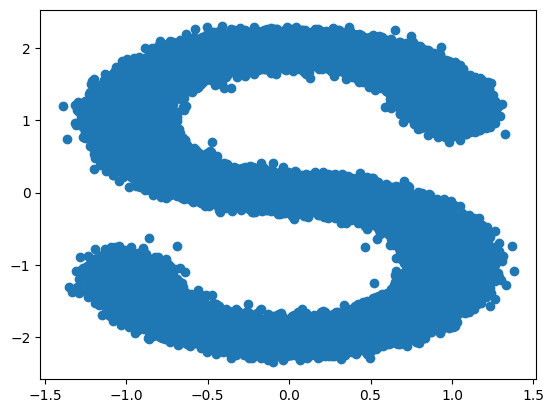

In [7]:
from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt

def toy_2d_data(n=100000):
    x, _ = make_s_curve(n, noise=0.1)
    x = x[:, [0, 2]]
    return x.astype('float32')

def visualize_toy_2d_dataset():
    data = toy_2d_data()
    plt.figure()
    plt.scatter(data[:, 0], data[:, 1])
    plt.show()

visualize_toy_2d_dataset()

## Training and Sampling of Diffusion Models

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:

0. Construct a class `Diffusion`
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and cmpute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))
* Training 100 epochs takes about 2 minutes on the Google Colab T4 GPU.


To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
*Note*: As a sanity check, when $\eta_t$ follows the DDPM setting as shown above, the resulted coefficient of $x_t$ and $\hat{\epsilon}$ should be the same as $A'$ and $B'$ you derived in Problem 1.2 (6) where $\alpha_t$ here corresponds to $\bar{\alpha_t}$ in Problem 1.

To run the reverse process, start from $x_1 \sim N(0, I)$. Then perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
*Note*:
* If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0
* For debugging, you can start with trying small number of epochs. To debug your training code, you can check whether the training and testing losses decrease properly. To debug your sampling code, you can check whether the generated distribution is close to the S-shape target distribution with large `num_steps`.
* To check your answer, the final text loss is roughly around 0.4.

In [35]:
import torch
import torch.nn as nn
import math
import numpy as np
import random

class Diffusion:
    def __init__(self, model, data_shape):
        """
        model: neural network to estimate eps_hat (MLP in this problem)
        data_shape: size of the input data, (2,) in this case
        """
        self.model = model
        self.data_shape = data_shape

    def loss(self, x):
        """
        x: the input data (without adding noise) from the dataloader
        Return:
            The loss (as a scalar averaged over all data in the batch)
        """
        # raise NotImplementedError("Please implement this")


        t = torch.rand(x.shape[0], device=x.device)
        epsilons = torch.randn_like(x)

        cos_t = torch.cos(math.pi/2 * t).unsqueeze(1)
        sin_t = torch.sin(math.pi/2 * t).unsqueeze(1)

        xt = (cos_t * x) + (sin_t * epsilons)

        predictions = self.model(xt, t)

        return nn.MSELoss()(predictions, epsilons)




    @torch.no_grad()
    def sample(self, n, num_steps):
        """
        n: number of samples to generate
        num_steps: number of steps in the diffusion sampling
        Return:
            The generated sample. Tensor with shape (n, *self.data_shape)
        """
        #raise NotImplementedError("Please implement this")
        samples = torch.randn(n, *self.data_shape)
        ts = torch.linspace(1 - 1e-4, 1e-4, num_steps + 1, device=samples.device)

        for sample_idx in range(n):
            x = samples[sample_idx]
            for step in range(num_steps):
                t = ts[step].item()
                tm1 = ts[step + 1].item()
                t_tensor = torch.tensor([t], dtype=x.dtype, device=x.device)

                eps_hat = self.model(x.unsqueeze(0), t_tensor).squeeze(0)


                alpha_t = torch.cos(torch.tensor(torch.pi/2 * t, dtype=x.dtype, device=x.device))
                alpha_tm1 = torch.cos(torch.tensor(torch.pi/2 * tm1, dtype=x.dtype, device=x.device))
                sigma_t = torch.sin(torch.tensor(torch.pi/2 * t, dtype=x.dtype, device=x.device))
                sigma_tm1 = torch.sin(torch.tensor(torch.pi/2 * tm1, dtype=x.dtype, device=x.device))

                ratio = sigma_tm1 / sigma_t
                inner = 1 - (alpha_t ** 2 / alpha_tm1 ** 2)
                inner = torch.clamp(inner, min=0)
                eta_t = ratio * torch.sqrt(inner)

                diff = sigma_tm1 ** 2 - eta_t ** 2
                diff = torch.clamp(diff, min=0)

                x = (alpha_tm1 * (x - sigma_t * eps_hat) / alpha_t +
                     torch.sqrt(diff) * eps_hat +
                     eta_t * torch.randn_like(x))
            # Save the final sample back to samples
            samples[sample_idx] = x
        return samples








    def __getattr__(self, name):
        if name in ['train', 'eval', 'parameters', 'state_dict', 'load_state_dict']:
            return getattr(self.model, name)
        return self.__getattribute__(name)


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_hidden_layers, timestep_dim=1):
        super().__init__()
        self.timestep_dim = timestep_dim
        prev_dim = input_dim + timestep_dim
        net = []
        dims = [hidden_dim] * n_hidden_layers + [input_dim]
        for i, dim in enumerate(dims):
            net.append(nn.Linear(prev_dim, dim))
            if i < len(dims) - 1:
                net.append(nn.ReLU())
            prev_dim = dim
        self.net = nn.Sequential(*net)

    def forward(self, x, t):
        x = torch.cat([x, t[:, None]], dim=1)
        return self.net(x)

In [36]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(model, train_loader, optimizer, scheduler):
    """
    model: model to train, the Diffusion class in this case.
    train_loader: dataloader for the train_data after normalization
    optimizer: use torch.optim.Adam
    scheduler: use optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
    )
    Return:
        Tensor with train loss of each batch
    """
    # raise NotImplementedError("Please implement this")

    losses = []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        loss = model.loss(batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
    return torch.tensor(losses)










@torch.no_grad()
def eval_loss(model, data_loader):
    """
    model: model to train, the Diffusion class in this case.
    data_loader: dataloader for the test_data after normalization
    Return:
        Scalar with the average test loss of each batch
    """
    #raise NotImplementedError("Please implement this")


    losses = []
    for batch in data_loader:
        loss = model.loss(batch)
        losses.append(loss.item())
    return sum(losses) / len(losses)

def get_lr(step, total_steps, warmup_steps, use_cos_decay):
    """
    Function that returns the learning rate for the specific step, used in defining the scheduler:
        scheduler = optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
        )
    """
    #raise NotImplementedError("Please implement this")

    if step < warmup_steps:
        return step / warmup_steps
    else:
        if use_cos_decay:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))
        else:
            return 1.0



def train_epochs(model, train_loader, test_loader, train_args):
    """
    model: model to train, the Diffusion class in this case.
    train_loader: dataloader for the train_data after normalization
    test_loader: dataloader for the test_data after normalization
    Return:
        Two np.array for all the train losses and test losses at each step
    """
    epochs, lr = train_args['epochs'], train_args['lr']
    warmup_steps = train_args.get('warmup', 0)
    use_cos_decay = train_args.get('use_cos_decay', False)
    #raise NotImplementedError("Please implement this")

    optimizer = optim.Adam(model.parameters(), lr=lr)
    total_steps = epochs * len(train_loader)
    scheduler = optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
        )
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        train_loss_tensor = train(model, train_loader, optimizer, scheduler)

        avg_test_loss = eval_loss(model, test_loader)

        train_losses.append(train_loss_tensor.numpy())

        test_losses.append(avg_test_loss)


        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1].mean():.4f}, Test Loss: {avg_test_loss:.4f}")


    return np.array(train_losses), np.array(test_losses)










In [56]:
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler

def toy_diffusion(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """
    # raise NotImplementedError("Please implement this")


    model = MLP(input_dim=2, hidden_dim=64, n_hidden_layers=4)
    diffusion = Diffusion(model, data_shape=(2,))
    scaler = StandardScaler()
    scaler.fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)

    train_dataset = torch.from_numpy(train_data)
    test_dataset = torch.from_numpy(test_data)

    train_loader = data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
    test_loader = data.DataLoader(test_dataset, batch_size=1024, shuffle=False)

    train_losses, test_losses = train_epochs(diffusion, train_loader, test_loader, {'epochs': 100, 'lr': 1e-3})


    samples_steps = []


    for steps in np.power(2, np.linspace(0, 9, 9)).astype(int):

        samples = diffusion.sample(2000, steps)
        samples = scaler.inverse_transform(samples.detach().cpu().numpy())
        samples_steps.append(samples)
        print("sampling step ", steps, " done")
    return np.concatenate(train_losses), test_losses, np.array(samples_steps)






















In [40]:
import os
from os.path import exists, dirname

def savefig(fname: str, show_figure: bool = True) -> None:
    if not exists(dirname(fname)):
        os.makedirs(dirname(fname))
    plt.tight_layout()
    plt.savefig(fname)
    if show_figure:
        plt.show()


def save_training_plot(
    train_losses: np.ndarray, test_losses: np.ndarray, title: str, fname: str
) -> None:
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label="train loss")
    plt.plot(x_test, test_losses, label="test loss")
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("NLL")
    savefig(fname)

In [41]:
def save_multi_scatter_2d(data: np.ndarray) -> None:
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    num_steps = np.power(2, np.linspace(0, 9, 9)).astype(int)
    for i in range(3):
        for j in range(3):
            axs[i, j].scatter(data[i * 3 + j, :, 0], data[i * 3 + j, :, 1])
            axs[i, j].set_title(f'Steps = {num_steps[i * 3 + j]}')
    savefig("results/p2_toy_samples.png")


def toy_save_results(fn):
    train_data = toy_2d_data(n=100000)
    test_data = toy_2d_data(n=10000)
    train_losses, test_losses, samples = fn(train_data, test_data)

    print(f"Final Test Loss: {test_losses[-1]:.4f}")

    save_training_plot(
        train_losses,
        test_losses,
        f"P2 Train Plot",
        f"results/p2_train_plot.png"
    )

    save_multi_scatter_2d(samples)

In [46]:
train_data = toy_2d_data(n=100000)
test_data = toy_2d_data(n=10000)

train_losses, test_losses, samples = toy_diffusion(train_data, test_data)

100%|██████████| 98/98 [00:01<00:00, 75.47it/s]


Epoch 1/100, Train Loss: 0.6511, Test Loss: 0.5096


100%|██████████| 98/98 [00:00<00:00, 110.98it/s]


Epoch 2/100, Train Loss: 0.4768, Test Loss: 0.4602


100%|██████████| 98/98 [00:00<00:00, 112.60it/s]


Epoch 3/100, Train Loss: 0.4576, Test Loss: 0.4412


100%|██████████| 98/98 [00:00<00:00, 113.75it/s]


Epoch 4/100, Train Loss: 0.4417, Test Loss: 0.4296


100%|██████████| 98/98 [00:00<00:00, 114.85it/s]


Epoch 5/100, Train Loss: 0.4366, Test Loss: 0.4317


100%|██████████| 98/98 [00:00<00:00, 110.76it/s]


Epoch 6/100, Train Loss: 0.4323, Test Loss: 0.4244


100%|██████████| 98/98 [00:00<00:00, 112.51it/s]


Epoch 7/100, Train Loss: 0.4305, Test Loss: 0.4285


100%|██████████| 98/98 [00:01<00:00, 84.24it/s]


Epoch 8/100, Train Loss: 0.4252, Test Loss: 0.4239


100%|██████████| 98/98 [00:00<00:00, 105.78it/s]


Epoch 9/100, Train Loss: 0.4260, Test Loss: 0.4208


100%|██████████| 98/98 [00:00<00:00, 105.74it/s]


Epoch 10/100, Train Loss: 0.4276, Test Loss: 0.4120


100%|██████████| 98/98 [00:00<00:00, 106.23it/s]


Epoch 11/100, Train Loss: 0.4249, Test Loss: 0.4275


100%|██████████| 98/98 [00:01<00:00, 79.20it/s]


Epoch 12/100, Train Loss: 0.4251, Test Loss: 0.4153


100%|██████████| 98/98 [00:01<00:00, 69.91it/s]


Epoch 13/100, Train Loss: 0.4240, Test Loss: 0.4206


100%|██████████| 98/98 [00:00<00:00, 100.83it/s]


Epoch 14/100, Train Loss: 0.4235, Test Loss: 0.4287


100%|██████████| 98/98 [00:00<00:00, 106.54it/s]


Epoch 15/100, Train Loss: 0.4236, Test Loss: 0.4109


100%|██████████| 98/98 [00:00<00:00, 101.02it/s]


Epoch 16/100, Train Loss: 0.4239, Test Loss: 0.4283


100%|██████████| 98/98 [00:00<00:00, 107.00it/s]


Epoch 17/100, Train Loss: 0.4245, Test Loss: 0.4209


100%|██████████| 98/98 [00:00<00:00, 106.20it/s]


Epoch 18/100, Train Loss: 0.4226, Test Loss: 0.4192


100%|██████████| 98/98 [00:00<00:00, 106.38it/s]


Epoch 19/100, Train Loss: 0.4135, Test Loss: 0.4225


100%|██████████| 98/98 [00:00<00:00, 106.52it/s]


Epoch 20/100, Train Loss: 0.4207, Test Loss: 0.4299


100%|██████████| 98/98 [00:00<00:00, 103.83it/s]


Epoch 21/100, Train Loss: 0.4204, Test Loss: 0.4211


100%|██████████| 98/98 [00:00<00:00, 103.68it/s]


Epoch 22/100, Train Loss: 0.4217, Test Loss: 0.4173


100%|██████████| 98/98 [00:00<00:00, 105.88it/s]


Epoch 23/100, Train Loss: 0.4185, Test Loss: 0.4193


100%|██████████| 98/98 [00:01<00:00, 73.82it/s]


Epoch 24/100, Train Loss: 0.4242, Test Loss: 0.4226


100%|██████████| 98/98 [00:01<00:00, 70.47it/s]


Epoch 25/100, Train Loss: 0.4183, Test Loss: 0.4129


100%|██████████| 98/98 [00:00<00:00, 105.77it/s]


Epoch 26/100, Train Loss: 0.4171, Test Loss: 0.4095


100%|██████████| 98/98 [00:01<00:00, 53.56it/s]


Epoch 27/100, Train Loss: 0.4190, Test Loss: 0.4268


100%|██████████| 98/98 [00:01<00:00, 65.30it/s]


Epoch 28/100, Train Loss: 0.4176, Test Loss: 0.4205


100%|██████████| 98/98 [00:01<00:00, 73.87it/s]


Epoch 29/100, Train Loss: 0.4166, Test Loss: 0.4240


100%|██████████| 98/98 [00:00<00:00, 104.53it/s]


Epoch 30/100, Train Loss: 0.4193, Test Loss: 0.4218


100%|██████████| 98/98 [00:00<00:00, 105.82it/s]


Epoch 31/100, Train Loss: 0.4201, Test Loss: 0.4136


100%|██████████| 98/98 [00:00<00:00, 106.05it/s]


Epoch 32/100, Train Loss: 0.4177, Test Loss: 0.4199


100%|██████████| 98/98 [00:00<00:00, 103.58it/s]


Epoch 33/100, Train Loss: 0.4189, Test Loss: 0.4157


100%|██████████| 98/98 [00:01<00:00, 70.53it/s]


Epoch 34/100, Train Loss: 0.4212, Test Loss: 0.4074


100%|██████████| 98/98 [00:01<00:00, 74.56it/s]


Epoch 35/100, Train Loss: 0.4205, Test Loss: 0.4029


100%|██████████| 98/98 [00:00<00:00, 104.05it/s]


Epoch 36/100, Train Loss: 0.4180, Test Loss: 0.4340


100%|██████████| 98/98 [00:00<00:00, 107.03it/s]


Epoch 37/100, Train Loss: 0.4193, Test Loss: 0.4156


100%|██████████| 98/98 [00:00<00:00, 106.64it/s]


Epoch 38/100, Train Loss: 0.4176, Test Loss: 0.4158


100%|██████████| 98/98 [00:00<00:00, 106.29it/s]


Epoch 39/100, Train Loss: 0.4157, Test Loss: 0.4167


100%|██████████| 98/98 [00:00<00:00, 104.23it/s]


Epoch 40/100, Train Loss: 0.4182, Test Loss: 0.4175


100%|██████████| 98/98 [00:00<00:00, 104.81it/s]


Epoch 41/100, Train Loss: 0.4156, Test Loss: 0.4216


100%|██████████| 98/98 [00:00<00:00, 107.20it/s]


Epoch 42/100, Train Loss: 0.4195, Test Loss: 0.4102


100%|██████████| 98/98 [00:00<00:00, 103.94it/s]


Epoch 43/100, Train Loss: 0.4137, Test Loss: 0.4232


100%|██████████| 98/98 [00:00<00:00, 104.01it/s]


Epoch 44/100, Train Loss: 0.4161, Test Loss: 0.4283


100%|██████████| 98/98 [00:01<00:00, 89.11it/s]


Epoch 45/100, Train Loss: 0.4156, Test Loss: 0.4183


100%|██████████| 98/98 [00:01<00:00, 57.89it/s]


Epoch 46/100, Train Loss: 0.4184, Test Loss: 0.4143


100%|██████████| 98/98 [00:01<00:00, 94.26it/s] 


Epoch 47/100, Train Loss: 0.4202, Test Loss: 0.4321


100%|██████████| 98/98 [00:00<00:00, 105.15it/s]


Epoch 48/100, Train Loss: 0.4182, Test Loss: 0.4270


100%|██████████| 98/98 [00:00<00:00, 105.97it/s]


Epoch 49/100, Train Loss: 0.4174, Test Loss: 0.4159


100%|██████████| 98/98 [00:00<00:00, 105.33it/s]


Epoch 50/100, Train Loss: 0.4171, Test Loss: 0.4321


100%|██████████| 98/98 [00:00<00:00, 105.18it/s]


Epoch 51/100, Train Loss: 0.4180, Test Loss: 0.4308


100%|██████████| 98/98 [00:00<00:00, 105.10it/s]


Epoch 52/100, Train Loss: 0.4177, Test Loss: 0.4173


100%|██████████| 98/98 [00:00<00:00, 106.40it/s]


Epoch 53/100, Train Loss: 0.4165, Test Loss: 0.4226


100%|██████████| 98/98 [00:00<00:00, 107.29it/s]


Epoch 54/100, Train Loss: 0.4141, Test Loss: 0.4021


100%|██████████| 98/98 [00:00<00:00, 105.40it/s]


Epoch 55/100, Train Loss: 0.4182, Test Loss: 0.4186


100%|██████████| 98/98 [00:00<00:00, 103.82it/s]


Epoch 56/100, Train Loss: 0.4152, Test Loss: 0.4141


100%|██████████| 98/98 [00:01<00:00, 74.46it/s]


Epoch 57/100, Train Loss: 0.4179, Test Loss: 0.4173


100%|██████████| 98/98 [00:01<00:00, 68.58it/s]


Epoch 58/100, Train Loss: 0.4152, Test Loss: 0.4193


100%|██████████| 98/98 [00:00<00:00, 103.78it/s]


Epoch 59/100, Train Loss: 0.4166, Test Loss: 0.4212


100%|██████████| 98/98 [00:00<00:00, 104.88it/s]


Epoch 60/100, Train Loss: 0.4138, Test Loss: 0.4200


100%|██████████| 98/98 [00:00<00:00, 104.36it/s]


Epoch 61/100, Train Loss: 0.4193, Test Loss: 0.4103


100%|██████████| 98/98 [00:00<00:00, 106.74it/s]


Epoch 62/100, Train Loss: 0.4128, Test Loss: 0.4123


100%|██████████| 98/98 [00:00<00:00, 107.55it/s]


Epoch 63/100, Train Loss: 0.4154, Test Loss: 0.4106


100%|██████████| 98/98 [00:01<00:00, 84.77it/s]


Epoch 64/100, Train Loss: 0.4179, Test Loss: 0.4177


100%|██████████| 98/98 [00:00<00:00, 104.34it/s]


Epoch 65/100, Train Loss: 0.4143, Test Loss: 0.4133


100%|██████████| 98/98 [00:00<00:00, 101.58it/s]


Epoch 66/100, Train Loss: 0.4172, Test Loss: 0.4260


100%|██████████| 98/98 [00:00<00:00, 107.24it/s]


Epoch 67/100, Train Loss: 0.4156, Test Loss: 0.4081


100%|██████████| 98/98 [00:01<00:00, 91.59it/s]


Epoch 68/100, Train Loss: 0.4150, Test Loss: 0.4264


100%|██████████| 98/98 [00:01<00:00, 70.44it/s]


Epoch 69/100, Train Loss: 0.4162, Test Loss: 0.4355


100%|██████████| 98/98 [00:01<00:00, 81.38it/s]


Epoch 70/100, Train Loss: 0.4143, Test Loss: 0.4180


100%|██████████| 98/98 [00:00<00:00, 104.58it/s]


Epoch 71/100, Train Loss: 0.4144, Test Loss: 0.4226


100%|██████████| 98/98 [00:00<00:00, 102.99it/s]


Epoch 72/100, Train Loss: 0.4168, Test Loss: 0.4145


100%|██████████| 98/98 [00:00<00:00, 102.36it/s]


Epoch 73/100, Train Loss: 0.4161, Test Loss: 0.4221


100%|██████████| 98/98 [00:00<00:00, 102.82it/s]


Epoch 74/100, Train Loss: 0.4148, Test Loss: 0.4038


100%|██████████| 98/98 [00:00<00:00, 104.73it/s]


Epoch 75/100, Train Loss: 0.4157, Test Loss: 0.4172


100%|██████████| 98/98 [00:00<00:00, 103.66it/s]


Epoch 76/100, Train Loss: 0.4143, Test Loss: 0.4171


100%|██████████| 98/98 [00:00<00:00, 104.35it/s]


Epoch 77/100, Train Loss: 0.4151, Test Loss: 0.4219


100%|██████████| 98/98 [00:00<00:00, 103.52it/s]


Epoch 78/100, Train Loss: 0.4155, Test Loss: 0.4127


100%|██████████| 98/98 [00:00<00:00, 105.13it/s]


Epoch 79/100, Train Loss: 0.4159, Test Loss: 0.4264


100%|██████████| 98/98 [00:01<00:00, 78.05it/s]


Epoch 80/100, Train Loss: 0.4189, Test Loss: 0.4196


100%|██████████| 98/98 [00:01<00:00, 68.65it/s]


Epoch 81/100, Train Loss: 0.4204, Test Loss: 0.4259


100%|██████████| 98/98 [00:00<00:00, 102.34it/s]


Epoch 82/100, Train Loss: 0.4170, Test Loss: 0.4188


100%|██████████| 98/98 [00:01<00:00, 82.11it/s]


Epoch 83/100, Train Loss: 0.4137, Test Loss: 0.4207


100%|██████████| 98/98 [00:00<00:00, 105.56it/s]


Epoch 84/100, Train Loss: 0.4185, Test Loss: 0.4264


100%|██████████| 98/98 [00:00<00:00, 105.75it/s]


Epoch 85/100, Train Loss: 0.4175, Test Loss: 0.4065


100%|██████████| 98/98 [00:00<00:00, 104.66it/s]


Epoch 86/100, Train Loss: 0.4184, Test Loss: 0.4139


100%|██████████| 98/98 [00:00<00:00, 103.19it/s]


Epoch 87/100, Train Loss: 0.4167, Test Loss: 0.4099


100%|██████████| 98/98 [00:00<00:00, 104.15it/s]


Epoch 88/100, Train Loss: 0.4171, Test Loss: 0.4056


100%|██████████| 98/98 [00:00<00:00, 105.35it/s]


Epoch 89/100, Train Loss: 0.4158, Test Loss: 0.4257


100%|██████████| 98/98 [00:00<00:00, 104.97it/s]


Epoch 90/100, Train Loss: 0.4140, Test Loss: 0.4136


100%|██████████| 98/98 [00:01<00:00, 97.32it/s] 


Epoch 91/100, Train Loss: 0.4155, Test Loss: 0.4162


100%|██████████| 98/98 [00:01<00:00, 71.55it/s]


Epoch 92/100, Train Loss: 0.4162, Test Loss: 0.4090


100%|██████████| 98/98 [00:01<00:00, 80.51it/s]


Epoch 93/100, Train Loss: 0.4158, Test Loss: 0.4145


100%|██████████| 98/98 [00:00<00:00, 104.09it/s]


Epoch 94/100, Train Loss: 0.4186, Test Loss: 0.4205


100%|██████████| 98/98 [00:00<00:00, 106.07it/s]


Epoch 95/100, Train Loss: 0.4141, Test Loss: 0.4059


100%|██████████| 98/98 [00:00<00:00, 106.49it/s]


Epoch 96/100, Train Loss: 0.4181, Test Loss: 0.4162


100%|██████████| 98/98 [00:00<00:00, 105.56it/s]


Epoch 97/100, Train Loss: 0.4136, Test Loss: 0.4233


100%|██████████| 98/98 [00:00<00:00, 102.06it/s]


Epoch 98/100, Train Loss: 0.4169, Test Loss: 0.4143


100%|██████████| 98/98 [00:00<00:00, 105.10it/s]


Epoch 99/100, Train Loss: 0.4170, Test Loss: 0.4201


100%|██████████| 98/98 [00:00<00:00, 104.83it/s]


Epoch 100/100, Train Loss: 0.4215, Test Loss: 0.4132
sampling step  1  done
sampling step  2  done
sampling step  4  done
sampling step  10  done
sampling step  22  done
sampling step  49  done
sampling step  107  done
sampling step  234  done
sampling step  512  done


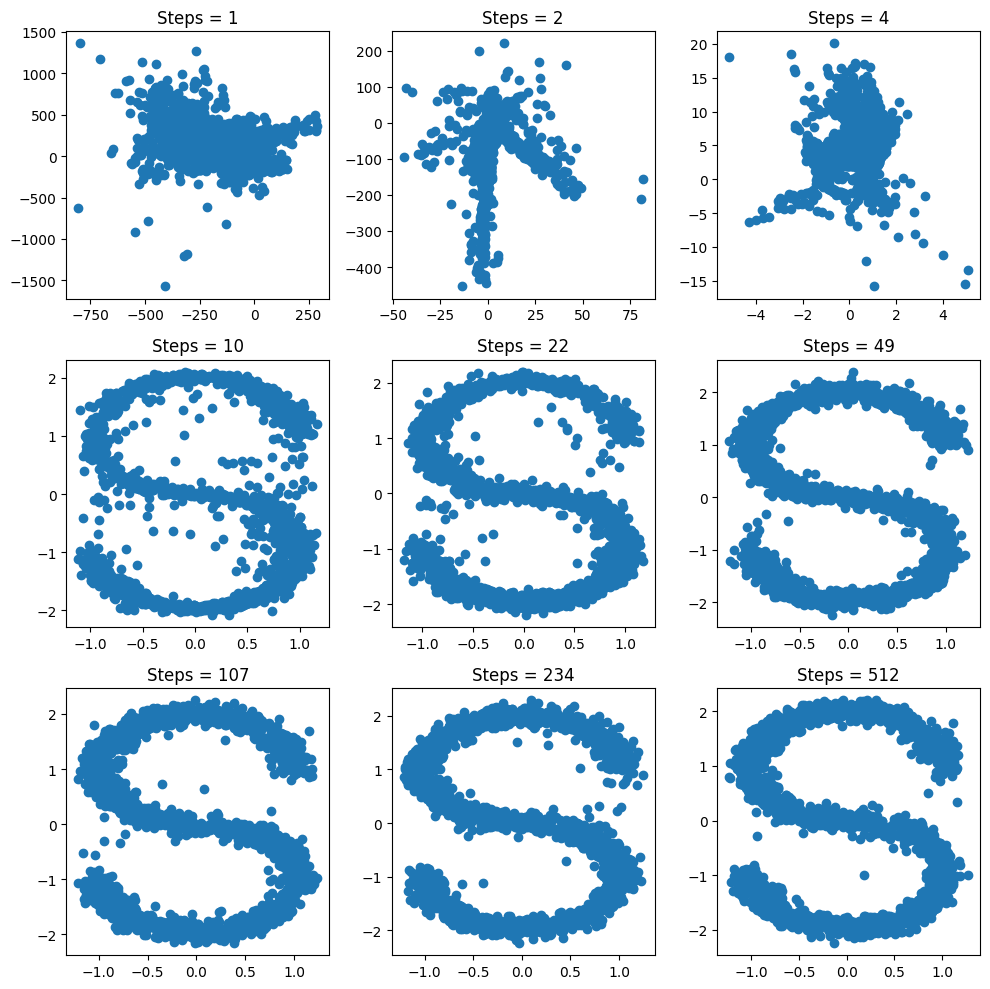

In [48]:
save_multi_scatter_2d(samples)

Text(0, 0.5, 'NLL')

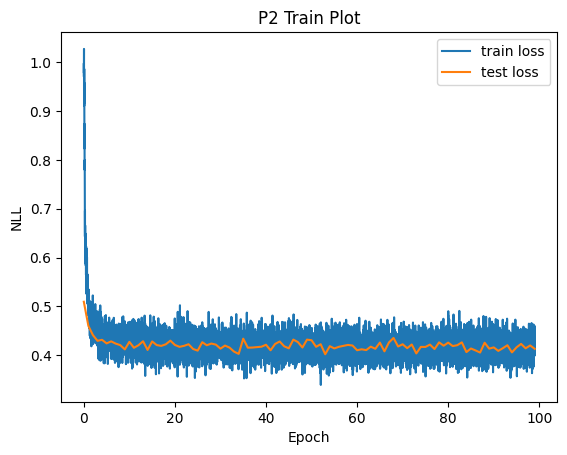

In [55]:
plt.figure()
n_epochs = len(test_losses) - 1
x_train = np.linspace(0, n_epochs, len(train_losses))
x_test = np.arange(n_epochs + 1)

plt.plot(x_train, train_losses, label = "train loss")
plt.plot(x_test, test_losses, label="test loss")
plt.legend()
plt.title("P2 Train Plot")
plt.xlabel("Epoch")
plt.ylabel("NLL")


# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file.

Specifically, for Problem 2 in this notebook, the pdf should contain:
- The generated figures `results/p2_train_plot.png` and `results/p2_toy_samples.png`